In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,skew
from scipy import stats
from sklearn.neighbors import KDTree
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV, ElasticNetCV, LassoCV,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from pykml import parser
#Import randomforest functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly
import plotly.express as px
import plotly.graph_objects as go 
import psycopg2
import pandas as pd
import matplotlib as plt
import seaborn as sns
from functools import reduce

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    dbname="glacier",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5433"
)

In [4]:
# Write your SQL query
query = 'SELECT * FROM public."glacier_data";'

# Execute the query and load the results into a DataFrame
clustered_df = pd.read_sql_query(query, conn)

# Print the DataFrame
clustered_df.head()

,line_type,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,prime_class,rec_status,release_dt,glac_stat,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,cluster,Value
0,2,13269,10804,495.176,0,0,0,4,okay,1177210698,1,Various (NSIDC),0,0,9,1,6,0,24,46.77
1,2,13726,11522,297.56,0,0,0,5,okay,1192067393,1,Various (NSIDC),0,0,9,1,5,0,67,55.43
2,2,13269,10804,162.882,0,0,0,5,okay,1150232094,1,Various (NSIDC),0,0,9,1,6,0,38,46.77
3,2,13269,10804,495.176,0,0,0,4,okay,1177210698,1,Various (NSIDC),0,0,9,1,6,0,24,46.77
4,2,13269,10804,495.176,0,0,0,4,okay,1177210698,1,Various (NSIDC),0,0,9,1,6,0,24,46.77


In [5]:
categorical_df = clustered_df[['rec_status','geog_area']]

In [6]:
categorical_df.head()

,rec_status,geog_area
0,okay,Various (NSIDC)
1,okay,Various (NSIDC)
2,okay,Various (NSIDC)
3,okay,Various (NSIDC)
4,okay,Various (NSIDC)


In [7]:
#Split numerical data to be merged later after converting categorical data to numerical for fitting
numerical_df = clustered_df.drop(columns=['rec_status','geog_area','conn_lvl','glac_stat'])

In [8]:
#View values to expect
numerical_df['surge_type'].value_counts()

surge_type
0    69119
3      280
2      150
1       23
Name: count, dtype: int64

In [9]:
numerical_df.head()

,line_type,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,prime_class,release_dt,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,cluster,Value
0,2,13269,10804,495.176,0,0,0,4,1177210698,0,9,1,6,0,24,46.77
1,2,13726,11522,297.56,0,0,0,5,1192067393,0,9,1,5,0,67,55.43
2,2,13269,10804,162.882,0,0,0,5,1150232094,0,9,1,6,0,38,46.77
3,2,13269,10804,495.176,0,0,0,4,1177210698,0,9,1,6,0,24,46.77
4,2,13269,10804,495.176,0,0,0,4,1177210698,0,9,1,6,0,24,46.77


In [14]:
clustered_df['line_type'].value_counts()

line_type
3    55560
2    14009
1        3
Name: count, dtype: int64

In [10]:
#Trying dummies
dummies = pd.get_dummies(categorical_df)
dummies

,rec_status_okay,geog_area_Alaska,geog_area_Chugach,geog_area_Conterminous USA,geog_area_Juneau area,geog_area_Kenai Peninsula,geog_area_Northern Cordillera,geog_area_Olympic Peninsula,geog_area_Prince William Sound,geog_area_Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS,geog_area_Various (GlobGlacier),geog_area_Various (NSIDC)
0,True,False,False,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,False,True
2,True,False,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False,False,True
4,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
69567,True,False,False,True,False,False,False,False,False,False,False,False
69568,True,False,False,True,False,False,False,False,False,False,False,False
69569,True,False,False,True,False,False,False,False,False,False,False,False
69570,True,False,False,True,False,False,False,False,False,False,False,False


In [11]:
to_train_df = pd.concat([numerical_df,dummies],axis=1)

In [12]:
to_train_df.head()

,line_type,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,prime_class,release_dt,surge_type,...,geog_area_Chugach,geog_area_Conterminous USA,geog_area_Juneau area,geog_area_Kenai Peninsula,geog_area_Northern Cordillera,geog_area_Olympic Peninsula,geog_area_Prince William Sound,geog_area_Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS,geog_area_Various (GlobGlacier),geog_area_Various (NSIDC)
0,2,13269,10804,495.176,0,0,0,4,1177210698,0,...,False,False,False,False,False,False,False,False,False,True
1,2,13726,11522,297.56,0,0,0,5,1192067393,0,...,False,False,False,False,False,False,False,False,False,True
2,2,13269,10804,162.882,0,0,0,5,1150232094,0,...,False,False,False,False,False,False,False,False,False,True
3,2,13269,10804,495.176,0,0,0,4,1177210698,0,...,False,False,False,False,False,False,False,False,False,True
4,2,13269,10804,495.176,0,0,0,4,1177210698,0,...,False,False,False,False,False,False,False,False,False,True


In [14]:
#Assign variables to X and Y for classification 
y = to_train_df['line_type']
X = to_train_df.drop(columns='line_type')

In [15]:
#Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9901109641809923

In [16]:
predictions = clf.predict(X_test)

In [18]:
#Display training matrix for explanation sake
training_matrix = confusion_matrix(y_test,predictions)
training_matrix_df = pd.DataFrame(training_matrix, index = ['Actual Internal Rock', 'Actual Debris Cover','Actual Glacier Bound'],
                                columns=['Predicted Internal Rock','Predicted Debris Cover','Predicted Glacier Bound'])
training_matrix_df

,Predicted Internal Rock,Predicted Debris Cover,Predicted Glacier Bound
Actual Internal Rock,0,0,1
Actual Debris Cover,0,3487,15
Actual Glacier Bound,0,156,13734


In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.96      1.00      0.98      3502
           3       1.00      0.99      0.99     13890

    accuracy                           0.99     17393
   macro avg       0.65      0.66      0.66     17393
weighted avg       0.99      0.99      0.99     17393



In [20]:
r_squared = r2_score(y_test,predictions)

In [21]:
print(r_squared)      

0.9375018505460224


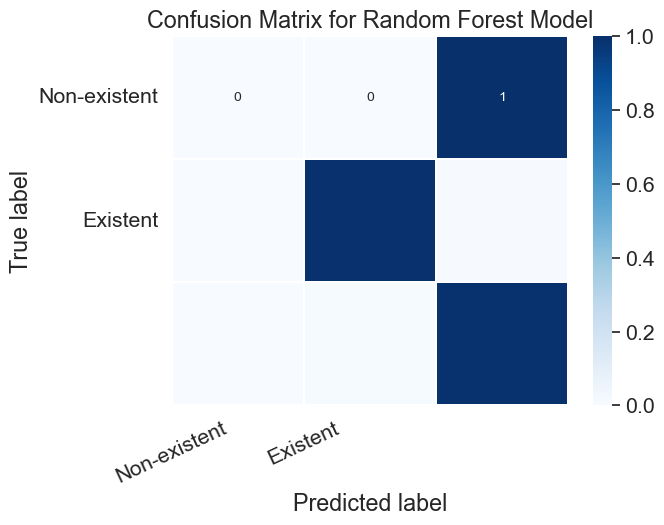

In [24]:
#Trying seaborn display for confusion matrix, not sure if it looks good
# Get and reshape confusion matrix data
training_matrix = training_matrix.astype('float') / training_matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
#plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(training_matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Non-existent','Existent']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()